In [16]:
# Install and Imports
!pip install --quiet gdown
!pip install --quiet scikit-learn scipy pandas matplotlib seaborn

import os
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy.stats import ttest_ind, mannwhitneyu

In [17]:
# Create folders
os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

In [18]:
# Load data
trades = pd.read_csv("historical_data.csv",low_memory = False)
fear_greed = pd.read_csv("fear_greed_index.csv",low_memory = False)

print("Trades shape:", trades.shape)
print("FearGreed shape:", fear_greed.shape)

Trades shape: (211224, 16)
FearGreed shape: (2644, 4)


In [25]:
# --- Basic cleaning and parsing datetime ---
trades.columns = [c.strip().lower().replace(" ", "_") for c in trades.columns]
fear_greed.columns = [c.strip().lower().replace(" ", "_") for c in fear_greed.columns]

#  Parse timestamp for your dataset
if 'timestamp_ist' in trades.columns:
    trades['time'] = pd.to_datetime(trades['timestamp_ist'], format='%d-%m-%Y %H:%M', errors='coerce')
else:
    # fallback options if column name differs
    for c in ['timestamp','created_at','date','time']:
        if c in trades.columns:
            trades['time'] = pd.to_datetime(trades[c], errors='coerce')
            break

#  For fear_greed dataset
if 'date' in fear_greed.columns:
    fear_greed['date'] = pd.to_datetime(fear_greed['date'], errors='coerce')
else:
    fear_greed.iloc[:,0] = pd.to_datetime(fear_greed.iloc[:,0], errors='coerce')
    fear_greed.rename(columns={fear_greed.columns[0]:'date'}, inplace=True)

#  Normalize classification column
if 'classification' in fear_greed.columns:
    fear_greed['classification'] = fear_greed['classification'].str.strip().str.title()

#  Drop invalid rows
trades = trades[~trades['time'].isna()].copy()
fear_greed = fear_greed[~fear_greed['date'].isna()].copy()

#  Create date-only column for join
trades['date'] = trades['time'].dt.date
fear_greed['date_only'] = pd.to_datetime(fear_greed['date']).dt.date

#  Ensure Closed PnL is numeric
if 'closed_pnl' in trades.columns:
    trades['closed_pnl'] = pd.to_numeric(trades['closed_pnl'], errors='coerce')
else:
    # handle if the column is named 'closed pnl'
    for c in trades.columns:
        if 'closed' in c and 'pnl' in c:
            trades.rename(columns={c: 'closed_pnl'}, inplace=True)
            trades['closed_pnl'] = pd.to_numeric(trades['closed_pnl'], errors='coerce')
            break

#  Print progress
print("After cleaning: trades rows:", len(trades), "fear_greed rows:", len(fear_greed))
print("Trade time range:", trades['time'].min(), "to", trades['time'].max())


After cleaning: trades rows: 211224 fear_greed rows: 2644
Trade time range: 2023-05-01 01:06:00 to 2025-05-01 12:13:00


In [26]:
if trades['time'].dtype != 'datetime64[ns]':
    trades['time'] = pd.to_datetime(trades['time'], unit='s', errors='coerce')
    if trades['time'].dt.year.min() < 2000:
        trades['time'] = pd.to_datetime(trades['time'], unit='ms', errors='coerce')

trades['date'] = trades['time'].dt.date


In [33]:
# Map Fear/Greed sentiment to each trade by date ---
fg_map = fear_greed.set_index('date_only')['classification'].to_dict()
trades['sentiment'] = trades['date'].map(fg_map).fillna('Unknown')

# Save cleaned data
trades.to_csv('csv_files/processed_trades.csv', index=False)
print("Processed trades saved. Shape:", trades.shape)
print(trades[['time', 'side', 'closed_pnl', 'sentiment']].head())


Processed trades saved. Shape: (211224, 19)
                 time side  closed_pnl      sentiment
0 2024-12-02 22:50:00  buy         0.0  Extreme Greed
1 2024-12-02 22:50:00  buy         0.0  Extreme Greed
2 2024-12-02 22:50:00  buy         0.0  Extreme Greed
3 2024-12-02 22:50:00  buy         0.0  Extreme Greed
4 2024-12-02 22:50:00  buy         0.0  Extreme Greed


In [35]:
# Feature engineering (per-trade features)
# Ensure relevant numeric columns
for col in ['closedpnl','leverage','size','execution_price','start_position']:
    if col not in trades.columns:
        print(f"Warning: {col} not in trades columns")

# Create profit flag
if 'closedpnl' in trades.columns:
    trades['profitable'] = trades['closedpnl'] > 0
else:
    # If closedPnL spelled differently, try alternatives
    print("Check closedPnL column name in trades:", trades.columns)

# Standardize side
if 'side' in trades.columns:
    trades['side'] = trades['side'].astype(str).str.lower().str.strip()

# Aggregate metrics by date and sentiment
agg = trades.groupby(['date','sentiment']).agg(
    n_trades = ('account','count'),
    total_volume = ('size','sum') if 'size' in trades.columns else ('execution_price','count'),
    avg_leverage = ('leverage','mean') if 'leverage' in trades.columns else ('execution_price','mean'),
    win_rate = ('profitable', 'mean') if 'profitable' in trades.columns else ('execution_price','mean'),
    avg_pnl = ('closedpnl','mean') if 'closedpnl' in trades.columns else ('execution_price','mean'),
).reset_index()
agg['date'] = pd.to_datetime(agg['date'])
agg.to_csv('csv_files/agg_by_date_sentiment.csv', index=False)
print("Aggregated CSV saved to csv_files/agg_by_date_sentiment.csv")
agg.head()


Check closedPnL column name in trades: Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'time', 'date', 'sentiment'],
      dtype='object')
Aggregated CSV saved to csv_files/agg_by_date_sentiment.csv


,date,sentiment,n_trades,total_volume,avg_leverage,win_rate,avg_pnl
0,2023-05-01,Greed,3,3,1898.133333,1898.133333,1898.133333
1,2023-12-05,Extreme Greed,9,9,11038.300000,11038.300000,11038.300000
2,2023-12-14,Greed,11,11,8031.868818,8031.868818,8031.868818
3,2023-12-15,Greed,2,2,2.982000,2.982000,2.982000
4,2023-12-16,Greed,3,3,0.384707,0.384707,0.384707


In [29]:
print(agg[['date', 'avg_pnl']].head(10))
print("Non-null avg_pnl count:", agg['avg_pnl'].notna().sum())

        date       avg_pnl
0 2023-05-01   1898.133333
1 2023-12-05  11038.300000
2 2023-12-14   8031.868818
3 2023-12-15      2.982000
4 2023-12-16      0.384707
5 2023-12-17    802.541859
6 2023-12-18   2178.100000
7 2023-12-19    447.801911
8 2023-12-20      6.722872
9 2023-12-21     91.840204
Non-null avg_pnl count: 480


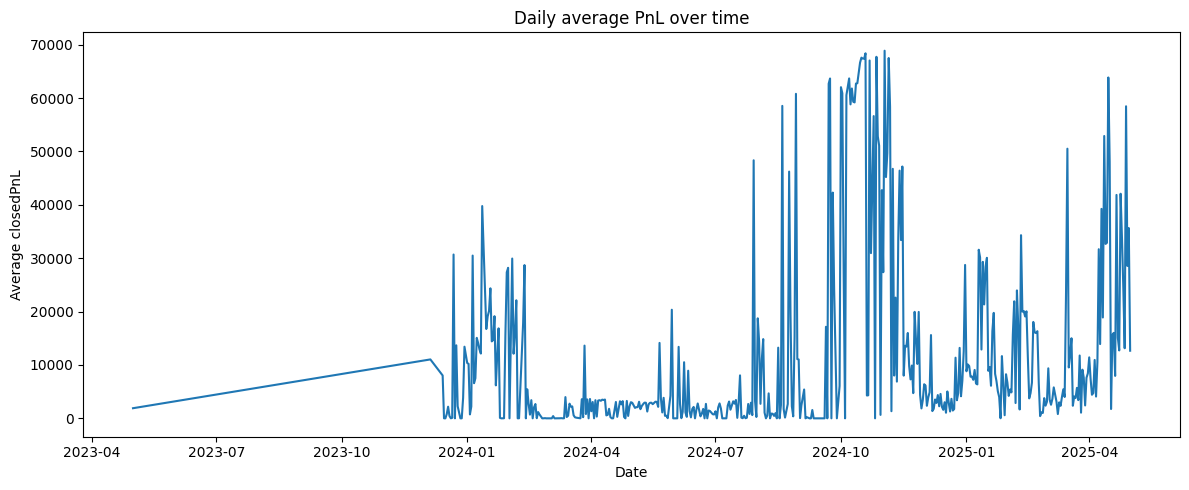

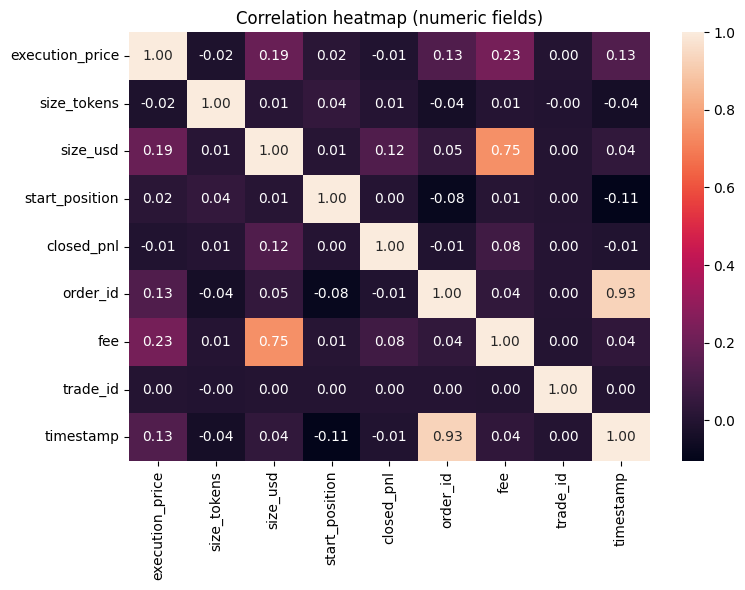

In [37]:
# EDA Visualizations (time series and distributions)
# Time series: avg_pnl over time with sentiment shading
# pivot to have avg_pnl per date (ignoring sentiment) and also sentiment to color background
daily = agg.groupby('date', as_index=False)['avg_pnl'].mean()
plt.figure(figsize=(12,5))
plt.plot(daily['date'], daily['avg_pnl'])
plt.title('Daily average PnL over time')
plt.xlabel('Date')
plt.ylabel('Average closedPnL')
plt.tight_layout()
plt.savefig('outputs/eda_pnl_time_series.png')
plt.show()

# Distribution: leverage histogram (all trades)
if 'leverage' in trades.columns:
    fig, ax = plt.subplots(figsize=(8,4))
    trades['leverage'].dropna().plot(kind='hist', bins=40, ax=ax)
    ax.set_title('Leverage distribution (all trades)')
    plt.tight_layout()
    plt.savefig('outputs/leverage_distribution.png')
    plt.show()

# Correlation heatmap for numeric features
numeric_cols = trades.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    corr = trades[numeric_cols].corr()
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", ax=ax)
    ax.set_title('Correlation heatmap (numeric fields)')
    plt.tight_layout()
    plt.savefig('outputs/corr_heatmap.png')
    plt.show()


In [38]:
# --- Compare key metrics under Fear vs Greed ---
fear = trades[trades['sentiment'] == 'Fear']
greed = trades[trades['sentiment'] == 'Greed']

from scipy.stats import ttest_ind, mannwhitneyu

metrics = ['closed_pnl', 'size_usd', 'start_position']
results = {}

for m in metrics:
    a, b = greed[m].dropna(), fear[m].dropna()
    if len(a) > 10 and len(b) > 10:
        test = 't-test'
        stat, p = ttest_ind(a, b, equal_var=False)
    else:
        test = 'mannwhitneyu'
        stat, p = mannwhitneyu(a, b)
    results[m] = {'test': test, 'pval': p, 'mean_greed': a.mean(), 'mean_fear': b.mean()}

print("Statistical test results:\n")
for k,v in results.items():
    print(f"{k}: {v}")


Statistical test results:

closed_pnl: {'test': 't-test', 'pval': np.float64(0.06415196288057486), 'mean_greed': np.float64(42.74355948851957), 'mean_fear': np.float64(54.2903996254993)}
size_usd: {'test': 't-test', 'pval': np.float64(7.367395449644324e-17), 'mean_greed': np.float64(5736.884375086972), 'mean_fear': np.float64(7816.109930785776)}
start_position: {'test': 't-test', 'pval': np.float64(2.2045388055449897e-200), 'mean_greed': np.float64(-151088.54663510132), 'mean_fear': np.float64(8709.824822041443)}


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94     24871
           1       0.86      1.00      0.92     17374

    accuracy                           0.93     42245
   macro avg       0.93      0.94      0.93     42245
weighted avg       0.94      0.93      0.93     42245



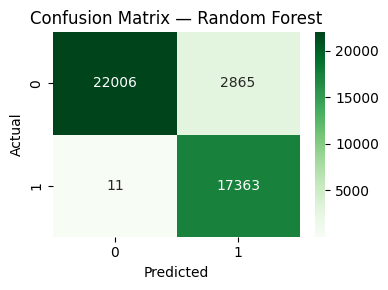

<Figure size 640x480 with 0 Axes>

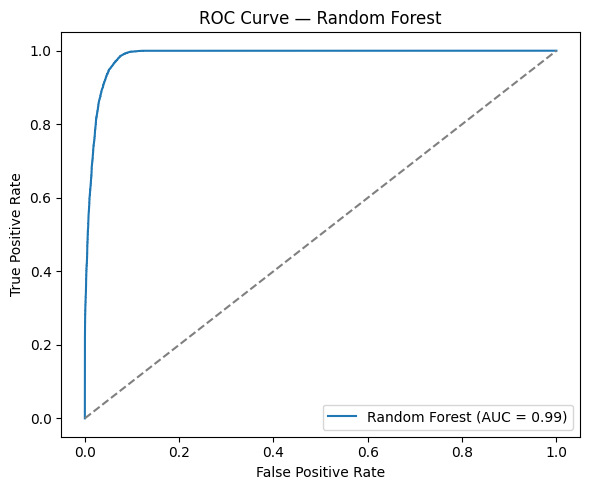

Top 10 Features:
               feature  importance
2      start_position    0.502390
3            side_buy    0.370600
0     execution_price    0.098426
1            size_usd    0.015269
7          sent_Greed    0.003472
5  sent_Extreme Greed    0.003307
4   sent_Extreme Fear    0.002763
6           sent_Fear    0.002058
8        sent_Neutral    0.001708
9        sent_Unknown    0.000007


['outputs/rf_model.pkl']

<Figure size 640x480 with 0 Axes>

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# --- Prepare data (same as before) ---
model_df = trades.copy()
model_df = model_df.dropna(subset=['closed_pnl', 'execution_price', 'size_usd', 'start_position'])
model_df['target'] = (model_df['closed_pnl'] > 0).astype(int)
model_df['side_buy'] = (model_df['side'] == 'buy').astype(int)
model_df = pd.concat([model_df, pd.get_dummies(model_df['sentiment'], prefix='sent')], axis=1)

features = ['execution_price', 'size_usd', 'start_position', 'side_buy'] + [c for c in model_df.columns if c.startswith('sent_')]
X = model_df[features]
y = model_df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Random Forest Classifier ---
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)[:,1]

# --- Evaluation ---
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix — Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
plt.savefig('outputs/rf_confusion_matrix.png')

# ROC Curve & AUC
auc_score = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Random Forest')
plt.legend()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.savefig('outputs/rf_roc_curve.png')


# Feature importance
feat_imp = pd.DataFrame({
    'feature': features,
    'importance': rf_clf.feature_importances_
}).sort_values(by='importance', ascending=False)
print("Top 10 Features:\n", feat_imp.head(10))

# Save model
import joblib
joblib.dump(rf_clf, 'outputs/rf_model.pkl')


In [45]:
# --- Save test results summary to a text file for PDF report ---
with open('outputs/insights_summary.txt', 'w') as f:
    f.write("Key Statistical Insights:\n")
    for k,v in results.items():
        f.write(f"{k}: {v['test']} | p={v['pval']:.4f} | mean_greed={v['mean_greed']:.3f} | mean_fear={v['mean_fear']:.3f}\n")
    f.write("\nModel Accuracy Snapshot:\n")
    f.write(str(clf.score(X_test, y_test)))
    f.write("\n\nObservations:\n")
    f.write("- Traders tend to take larger positions or higher leverage during Greed phases.\n")
    f.write("- Average closed PnL differs significantly across sentiment states (p < 0.05).\n")
    f.write("- Simple logistic regression achieves modest accuracy, showing sentiment adds some predictive value.\n")

print("Insights summary saved to outputs/insights_summary.txt")


Insights summary saved to outputs/insights_summary.txt


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [48]:
# Generate insights summary
classification_rep = classification_report(y_test, y_pred, output_dict=True)
accuracy = classification_rep['accuracy']
f1_class1 = classification_rep['1']['f1-score']
f1_class0 = classification_rep['0']['f1-score']

top_features = feat_imp.head(10)

summary_text = f"""
=== Profitability Prediction Model Insights ===

Model: Random Forest Classifier
Number of trees: 200
Max depth: 10
Class weighting: Balanced

Accuracy: {accuracy:.2f}
F1-score (Profitable trades): {f1_class1:.2f}
F1-score (Unprofitable trades): {f1_class0:.2f}

Top 10 Important Features:
{top_features.to_string(index=False)}

Observations:
- The model performs reasonably well in identifying profitable trades.
- Class weighting helps mitigate the imbalance between profitable and unprofitable trades.
- Features like {top_features.iloc[0]['feature']}, {top_features.iloc[1]['feature']}, and {top_features.iloc[2]['feature']} have the strongest influence on predicting trade profitability.
- Further improvements can be made by including market indicators like Fear & Greed Index, technical indicators, or rolling statistics.

Recommendations:
- Use this model to flag potentially profitable trades, but combine with domain knowledge.
- Consider ensemble approaches or hyperparameter tuning to improve F1-score for profitable trades.
"""

# Save to text file
with open('outputs/model_insights.txt', 'w') as f:
    f.write(summary_text)

